In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import segmentation_models_pytorch as smp
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

import params as pm
from evaluate import calculate_metrics, evaluate
from georefinject import geo_inject
from map_dataloader import (Dataset_Inference, Map_Dataset, get_preprocessing,
                            get_training_augmentation,
                            get_validation_augmentation)
from utils import convert_to_color, get_balanced_weights, visualize

In [2]:
params = pm.get_params()
params

{'main_dir': 'C:\\Users\\burak\\Desktop',
 'experiment_log': 'upp_r50',
 'data_dir': 'C:\\Users\\burak\\Desktop\\map_data\\Dataset',
 'log_path': 'C:\\Users\\burak\\Desktop\\map_exp\\5cls_2',
 'inference_ims_input': 'C:\\Users\\burak\\Desktop\\map_data\\all_dataset_ims',
 'inference_save_dir': 'C:\\Users\\burak\\Desktop\\map_data\\save_geo',
 'ENCODER': 'resnext50_32x4d',
 'ENCODER_WEIGHTS': 'imagenet',
 'CLASSES': array([0, 1, 2, 3, 4, 5]),
 'ACTIVATION': 'softmax2d',
 'DEVICE': 'cuda',
 'batch_size': 18,
 'mul_factor': 5,
 'lr': 0.0001,
 'n_epoch': 50,
 'ig_ch': [0],
 'n_workers': 0}

In [3]:
data_dir = params['data_dir']

x_train_dir = os.path.join(data_dir, 'Train', 'Image')
y_train_dir = os.path.join(data_dir, 'Train', 'Mask')

x_valid_dir = os.path.join(data_dir, 'Val', 'Image')
y_valid_dir = os.path.join(data_dir, 'Val', 'Mask')

x_test_dir = os.path.join(data_dir, 'Test', 'Image')
y_test_dir = os.path.join(data_dir, 'Test', 'Mask')

### sanity check 

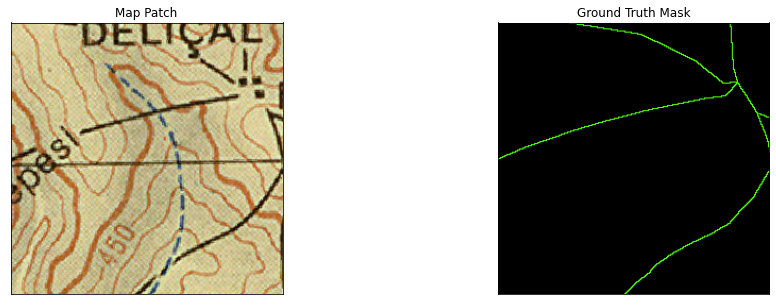

In [4]:
 for i in range(1):
    dataset = Map_Dataset(x_train_dir, y_train_dir)

    image, mask = dataset[np.random.randint(len(dataset))] # get some sample
    image = image.detach().cpu().numpy()
    mask  = mask.detach().cpu().numpy()

    mask0 = np.transpose(mask, (1,2,0))
    
    mask1 = np.argmax(mask0, axis = 2)
    image = np.transpose(image, (1,2,0)).astype('uint8')
    mask = convert_to_color(mask1)

    visualize(
        map_patch = image,
        ground_truth_mask = mask)

In [ ]:
train_dataset = Map_Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation= get_training_augmentation(), 
    preprocessing= None, 
)

valid_dataset = Map_Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation= get_validation_augmentation(), 
    preprocessing= None,
)

In [ ]:
train_sampler = WeightedRandomSampler(get_balanced_weights(train_dataset), len(train_dataset) * params['mul_factor'])
valid_sampler = WeightedRandomSampler(get_balanced_weights(valid_dataset), len(valid_dataset) * params['mul_factor'])

In [ ]:
train_loader = DataLoader(train_dataset,
                         batch_size=params['batch_size'], 
                         sampler=train_sampler, 
                         pin_memory=True,
                         prefetch_factor=2,
                         persistent_workers=False,
                         num_workers=params['n_workers'])

valid_loader = DataLoader(valid_dataset, 
                          batch_size=params['batch_size'],
                          pin_memory=True,
                          prefetch_factor=2,
                          persistent_workers=False,
                          num_workers=params['n_workers'])

### model, loss, metrics, and optimizer 

In [5]:
model = smp.UnetPlusPlus(encoder_name=params['ENCODER'], 
                        encoder_weights= params['ENCODER_WEIGHTS'], 
                        classes=len(params['CLASSES']), 
                        activation=params['ACTIVATION'])

loss = smp.utils.losses.DiceLoss(ignore_channels=params['ig_ch']) 

metrics = [smp.utils.metrics.Fscore(threshold=0.5,ignore_channels=params['ig_ch']),
            smp.utils.metrics.Precision(threshold=0.5,ignore_channels=params['ig_ch']), 
            smp.utils.metrics.Recall(threshold=0.5,ignore_channels=params['ig_ch'])]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=params['lr']),
])

### training

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=params['DEVICE'],
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=params['DEVICE'],
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, params['n_epoch']-1):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, os.path.join(params['log_path'],
         '.\{}.pth'.format(params['experiment_log'])))
        print('Model saved!')

### evaluation    

In [6]:
test_dataset = Map_Dataset(
    x_test_dir,
    y_test_dir,
)

test_dataloader = DataLoader(test_dataset,
                            batch_size=params['batch_size'])
                            
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=params['DEVICE'],
)

In [42]:
best_model = torch.load(os.path.join(params['log_path'], '.\{}.pth'.format(params['experiment_log'])))
best_model = best_model.cuda()

In [8]:
y_preds, ys = evaluate(best_model, test_dataset)
f1, prec, rec, jacc, acc = calculate_metrics(y_preds, ys)

100%|██████████| 708/708 [00:36<00:00, 19.61it/s]


In [9]:
print("-----f1---------prec---------rec---------jacc")
print("",np.stack([f1, prec, rec, jacc],axis=-1))
print("-----acc-----")
print(acc)

-----f1---------prec---------rec---------jacc
 [[0.46871238 0.44565036 0.49429154 0.30609036]
 [0.43626897 0.35941345 0.55493377 0.27899233]
 [0.52158074 0.44052333 0.63919407 0.35279623]
 [0.54980531 0.4600144  0.68315049 0.37912517]
 [0.35451379 0.25771573 0.56776722 0.21544622]]
-----acc-----
0.9873490198857366


### inference results

0it [00:00, ?it/s]<ipython-input-60-28d9ca285f49>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
<ipython-input-60-28d9ca285f49>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(tensor, device = 'cuda')


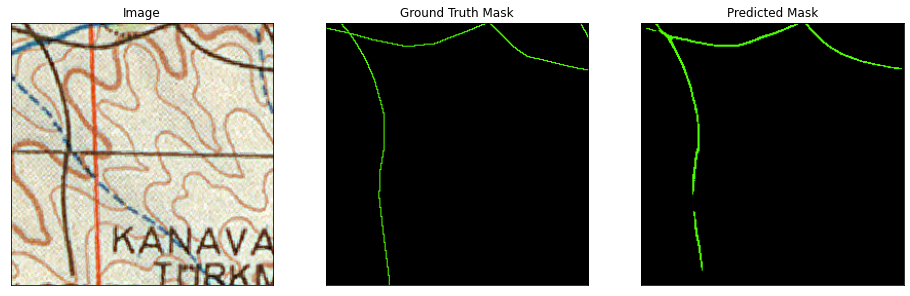

1it [00:00,  3.09it/s]

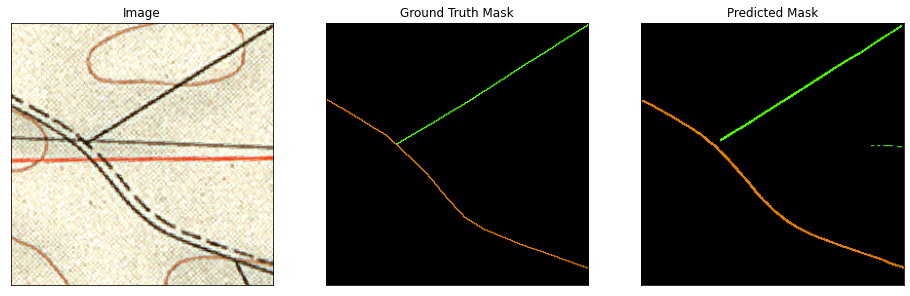

2it [00:00,  2.99it/s]


In [60]:
import tqdm

best_model = best_model.cuda()

for idx,i in tqdm.tqdm(enumerate(range(2))):
    
    i = np.random.randint(0, len(test_dataset))
    image = np.transpose(test_dataset[i][0].detach().cpu().numpy(),(1,2,0))

    gt_mask = np.transpose(test_dataset[i][1].detach().cpu().numpy() ,(1,2,0))
    
    gt_max = np.argmax(gt_mask, axis=-1)
    gt_color = convert_to_color(gt_max)    

    x_tensor = test_dataset[i][0]
    tensor = torch.unsqueeze(torch.tensor(x_tensor), axis = 0)
    tensor = tensor.float() 
    tensor = torch.tensor(tensor, device = 'cuda')

    pr_mask = best_model.predict(tensor).detach().cpu().numpy()
    pr_mask = pr_mask.squeeze()
    pr_max  = np.argmax(pr_mask.squeeze(), 0)
    
    pr_max11 = convert_to_color(pr_max)
                       
    visualize(image=image.astype('uint8'),  
            ground_truth_mask=gt_color,  
            predicted_mask=pr_max11) 


### export with georef 

In [ ]:
inference_dataset = Dataset_Inference(sample_ids=True,
                                images_dir=params['inference_ims_input'], 
                                augmentation=None, 
                                preprocessing=None)

In [ ]:
geo_inject(inference_dataset=inference_dataset,
           model=best_model.cuda(),
           out_path=params['inference_save_dir'])

### end